<a href="https://colab.research.google.com/github/MorningStarTM/brain_cancer_detection/blob/main/Tumor_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from glob import glob
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import*
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
#parameters
HEIGHT, WIDTH = 224, 224
CHANNEL = 3
num_class = 3
batch_size = 64
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

#Data Pipeline

In [3]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))
    
    #size of split 
    split_size = int(len(images) * split)

    #split the data
    train_data, valid_data = train_test_split(images, test_size=split_size, random_state=42)
    train_data, test_data = train_test_split(train_data, test_size=split_size, random_state=42)

    return train_data, valid_data, test_data 

In [4]:
#process the image
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [224, 224])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [5]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 4)
    image.set_shape([224, 224, 3])
    labels.set_shape(4)
  
    return image, labels

In [6]:
#tensorflow dataset
def tf_dataset(images, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    return dataset

#Model

In [7]:
#input layer
inputs = Input(shape=(WIDTH, HEIGHT, CHANNEL))

In [8]:
#convolutional layer
conv_x = Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(inputs)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)


conv_x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(1,1))(conv_x)
conv_x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = BatchNormalization()(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

#flatting
flatten = Flatten()(conv_x)
conv_x = Dense(16, activation='relu')(flatten)
con_x = Dropout(0.3)(conv_x)
#adding Dense layer with number of class 
outputs = Dense(4, activation='softmax')(conv_x)

In [9]:
model = Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640  

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=['accuracy'])

In [12]:
model_file = "/content/drive/MyDrive/CNN_Models/tumor_classfication_1.h5"
csv_file = "/content/drive/MyDrive/Model CSV/tumor_classification.csv"

In [13]:
#initialize the callbakcs
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    CSVLogger(csv_file),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

In [14]:
data_path = "/content/drive/MyDrive/DataSet/brain_cancer/Training"

In [15]:
#split the dataset
x_train, x_valid, x_test = load_data(data_path)
print(f"Train:{len(x_train)} - Test:{len(x_test)} - Valid:{len(x_valid)}")

Train:4586 - Test:573 - Valid:573


In [16]:
#tensor dataset
train_df = tf_dataset(x_train)
test_df = tf_dataset(x_test)
valid_df = tf_dataset(x_valid)

In [17]:
model.fit(
    train_df,
    validation_data=valid_df,
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 1.5184 - accuracy: 0.3251
Epoch 1: val_loss improved from inf to 1.39548, saving model to /content/drive/MyDrive/CNN_Models/tumor_classfication_1.h5
72/72 [==============================] - 49s 515ms/step - loss: 1.5184 - accuracy: 0.3251 - val_loss: 1.3955 - val_accuracy: 0.2269 - lr: 1.0000e-06
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.4274
Epoch 2: val_loss did not improve from 1.39548
72/72 [==============================] - 33s 459ms/step - loss: 1.2585 - accuracy: 0.4274 - val_loss: 1.4002 - val_accuracy: 0.2426 - lr: 1.0000e-06
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.5020
Epoch 3: val_loss did not improve from 1.39548
72/72 [==============================] - 32s 446ms/step - loss: 1.1344 - accuracy: 0.5020 - val_loss: 1.3991 - val_accuracy: 0.2443 - lr: 1.0000e-06
Epoch 4/50
72/72 [==============================] - ET

#Model Evaluation

In [18]:
model.evaluate(test_df)

9/9 [==============================] - 4s 393ms/step - loss: 0.4298 - accuracy: 0.8394


[0.42976856231689453, 0.8394415378570557]

##Model evaluation with confusion matrix

In [19]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_mark = np.arange(len(classes))
  plt.xticks(tick_mark, classes, rotation=45)
  plt.yticks(tick_mark, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
    print("normalized confusion matrix")

  else:
    print("confusion matrix without normalization")
  
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.xlabel("predicted label")
  plt.ylabel("True label")

In [20]:
#prediction
prediction = model.predict(test_df, verbose=0)

In [21]:
#scale the predicted value
np.around(prediction)

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [22]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [23]:
#function for get labels of test set
def get_test_data_class(test_path):
  names = []
  for i in test_path:
    name = i.split("/")[-2]
    name_idx = class_names.index(name)
    names.append(name_idx)
  names = np.array(names, dtype=np.int32)
  return names

In [24]:
classes = get_test_data_class(x_test)

In [25]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

confusion matrix without normalization


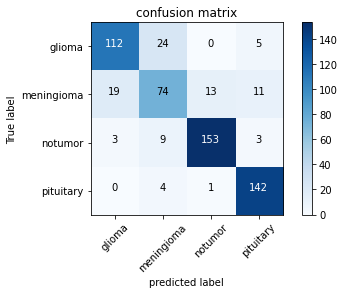

In [26]:
plt_confusion_matrix(cm=cm, classes=class_names, title="confusion matrix", )

In [28]:
#save model architecture and weights separetely
model_json = model.to_json()
with open("/content/drive/MyDrive/CNN_Models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/CNN_Models/tumor_model_83.h5")